In [1]:
from simulations import queue_sim
import math
import numpy as np
import matplotlib.pyplot as plt

Função de Simulação para Obter Trace:

In [2]:
def simulateAndGetFilteredMM1Trace(lamda, mu):
    data = queue_sim(lamda, mu, max_events=10000, runs=1).data
    filter = data['type'] == 's'
    filtered_served_events = data[filter]
    trace = filtered_served_events['N'].to_numpy()
    return trace

Funções Auxiliares para Plotar Gráficos de PDF e CDF:

In [3]:
def plot_rho_pdf(samples, bins=100):
    weights = np.ones_like(samples)/len(samples)
    plt.hist(samples, weights=weights, bins=bins)

def plot_rho_cdf(samples, bins=100):
    weights = np.ones_like(samples)/len(samples)
    plt.hist(samples, weights=weights, bins=bins, cumulative=True)

Algoritmo MCMC de Inferência:

In [4]:
def calcMetropolisHastingsAcceptanceRatio(proposal, current, traceSum, traceLength):
    if(0 > proposal or proposal > 1): return 0
    # A fórmula da distribuição f(rho|v), como introduzida no enunciado do trabalho, resultaria na seguinte razão (a distribuição de proposta é omitida por ser simétrica):
    #   ((proposal**traceSum * (1 - proposal)**traceLength) * K) / ((current**traceSum * (1 - current)**traceLength) * K)
    # A constante K estará presente tanto no numerador quando denominador, podendo ser eliminada:
    #   (proposal**traceSum * (1 - proposal)**traceLength) / (current**traceSum * (1 - current)**traceLength)
    # A expressão acima, conteria no numerador e denominador números extremamente pequenos devido aos expoentes presentes.
    # Desse modo, aplicamos a função exponencial e logaritmica sequencialmente para evitar divisões por zero e números infinitos causados por erros de precisão:
    logRatio = ((np.log(proposal)*traceSum) + (np.log(1 - proposal)*traceLength)) - ((np.log(current)*traceSum) + (np.log(1 - current)*traceLength))
    if logRatio > 1: return 1
    return np.exp(logRatio)


def mcmcSampleRhoGivenTrace(traceSum, traceLength, initialRho=0.5, iterations=100000, burnIn=1000):

    currentRho = initialRho
    totalAccepted = 0
    totalRejected = 0

    ### METROPOLIS-HASTINGS ###
    doneWithBurnIn = False
    for i in range(iterations):
        if i >= burnIn and not doneWithBurnIn:
            samples = [currentRho]
            doneWithBurnIn = True
        proposalRho = np.random.uniform(0, 1)
        acceptanceRatio = calcMetropolisHastingsAcceptanceRatio(proposalRho, currentRho, traceSum, traceLength)
        if acceptanceRatio >= 1 or acceptanceRatio > np.random.uniform(0, 1):
            currentRho = proposalRho
            if doneWithBurnIn:
                samples.append(proposalRho)
                totalAccepted += 1
        elif doneWithBurnIn:
            samples.append(currentRho)
            totalRejected += 1
    ############################

    print('Mean Rho from MCMC: ', np.mean(samples))
    print('Variance: ', np.var(samples))
    
    return samples

Execução:

In [5]:
trace = simulateAndGetFilteredMM1Trace(lamda=7, mu=10)
samples = mcmcSampleRhoGivenTrace(traceSum=sum(trace), traceLength=len(trace), iterations=1000000, initialRho=0.5, burnIn=1000)
print('m = ', len(trace))
print('y = ', sum(trace))

Mean Rho from MCMC:  0.7180709411345482
Variance:  1.1494156473616166e-05
m =  4997
y =  12725


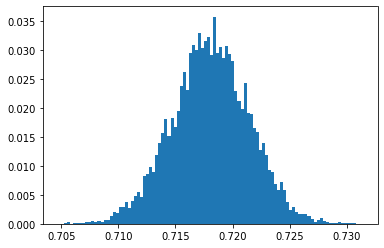

In [6]:
plot_rho_pdf(samples, bins=100)

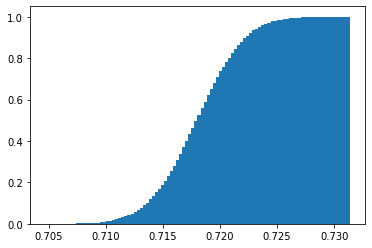

In [7]:
plot_rho_cdf(samples, bins=100)

Validação de Corretude (demora para rodar):

In [8]:
def getConfidenceInterval(samples, confidence_rate = 1.96):
    x = np.mean(samples)
    n = len(samples)
    s = np.std(samples)
    z = confidence_rate
    return (x - z*(s/math.sqrt(n)), x + z*(s/math.sqrt(n)))

In [9]:
def simulateTracesAndEstimateRho(lamda, mu, numberOfTraces = 10000):
    estimates = []
    for _ in range(numberOfTraces):
        trace = simulateAndGetFilteredMM1Trace(lamda, mu)
        rhoGivenTrace = np.mean(mcmcSampleRhoGivenTrace(sum(trace), len(trace)))
        estimates.append(rhoGivenTrace)

    print('Real Rho: ', lamda/mu)
    print('Average of Estimated Rhos: ', sum(estimates)/len(estimates))
    print('Confidence Interval: ', getConfidenceInterval(estimates))
    return estimates